## Business and Data understanding
The dataset used in this project is from kaggle that includes user reviews and ratings for courses on Coursera.This dataset is significant for this project because the reviews from the users are fundamental to making insightful decisions to improve the user experince and on the platform

## Problem Statement
The aim of this project is to determine factors that contribute to higher course ratings and how coursera can optimize course material to improve user satisfaction and engagement

In [9]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
import re


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import KMeans
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
#from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [10]:
#read in the data
data=pd.read_csv("reviews.csv")
data.head(10)

Id                                             Review  Label
0   0                               good and interesting      5
1   1  This class is very helpful to me. Currently, I...      5
2   2  like!Prof and TAs are helpful and the discussi...      5
3   3  Easy to follow and includes a lot basic and im...      5
4   4  Really nice teacher!I could got the point eazl...      4
5   5  Great course - I recommend it for all, especia...      5
6   6    One of the most useful course on IT Management!      5
7   7  I was disappointed because the name is mislead...      3
8   8    Super content. I'll definitely re-do the course      5
9   9  One of the excellent courses at Coursera for i...      5

In [11]:
data.describe()

Id          Label
count  107018.000000  107018.000000
mean    53508.500000       4.581145
std     30893.579891       0.860956
min         0.000000       1.000000
25%     26754.250000       4.000000
50%     53508.500000       5.000000
75%     80262.750000       5.000000
max    107017.000000       5.000000

### Data Preparation 
This specific dataset has two columns the reviews column and the rating column which will be the necessary columns required to come to a conclusion  on this project

In [12]:
# Check for missing values
print(data.isnull().sum())

Id        0
Review    0
Label     0
dtype: int64


the dataset does not have missing values

### EDA 
Exploratory Data Analysis

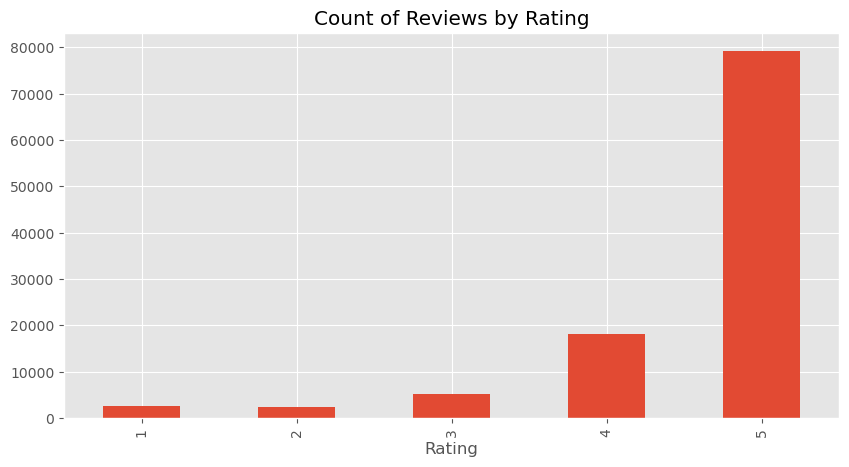

In [13]:
#ratings distribution
ax = data['Label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Rating')
plt.show()


the bar graph above shows how course ratings are distributed. Lower ratings are lesser and the numbers keep on rising as the rating improves

In [14]:
# Tokenize and clean text
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    words = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    words = [word for word in words if word.isalnum() and word not in stop_words]  # Remove stopwords
    return " ".join(words)
data["Cleaned_Review"] = data["Review"].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jessm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


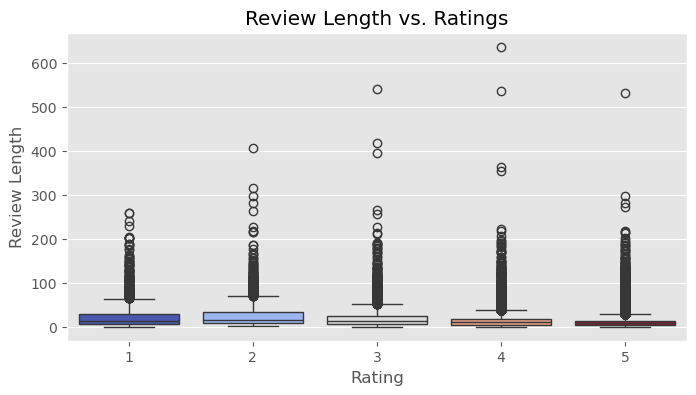

In [15]:
# Review length vs. rating
data["Review_Length"] = data["Cleaned_Review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.boxplot(x=data["Label"], y=data["Review_Length"], hue=data["Label"], palette="coolwarm", legend=False)
plt.title("Review Length vs. Ratings")
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.show()


the length of the review does not affect how the user rates a course

### Vader Sentiment Scoring

In [16]:

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Ensure 'Id' exists in data
if "Id" not in data.columns:
    print("Error: Column 'Id' not found in DataFrame. Available columns:", data.columns)
    exit()

# Perform sentiment analysis
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row.get("Review", "")  # Handle missing 'Review' column safely
    myid = row["Id"]  # Ensure 'Id' exists
    res[myid] = sia.polarity_scores(text)

# Convert results dictionary to DataFrame
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})  # Ensure 'Id' exists

# Merge sentiment scores with original data
vaders = vaders.merge(data, how='left', on='Id')

# Show first few rows
print(vaders.head())


  0%|          | 0/107018 [00:00<?, ?it/s]

   Id  neg    neu    pos  compound  \
0   0  0.0  0.152  0.848    0.6808   
1   1  0.0  0.866  0.134    0.4754   
2   2  0.0  0.575  0.425    0.8843   
3   3  0.0  0.701  0.299    0.5719   
4   4  0.0  0.794  0.206    0.3266   

                                              Review  Label  \
0                               good and interesting      5   
1  This class is very helpful to me. Currently, I...      5   
2  like!Prof and TAs are helpful and the discussi...      5   
3  Easy to follow and includes a lot basic and im...      5   
4  Really nice teacher!I could got the point eazl...      4   

                                      Cleaned_Review  Review_Length  
0                                   good interesting              2  
1  class helpful currently still learning class m...             11  
2  like prof tas helpful discussion among student...             12  
3  easy follow includes lot basic important techn...              9  
4       really nice teacher could got poin

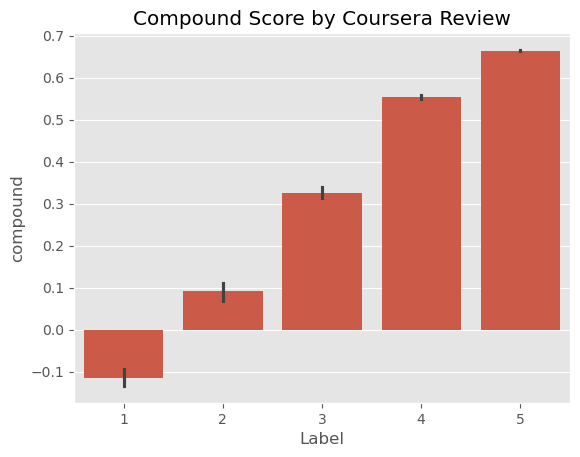

In [17]:
ax = sns.barplot(data=vaders, x='Label', y='compound')
ax.set_title('Compound Score by Coursera Review')
plt.show()

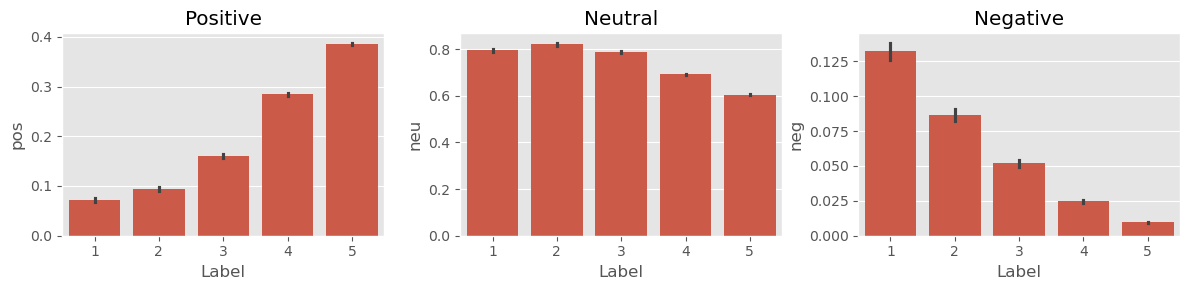

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Label', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Roberta Pretrained Model


In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
def polarity_scores_roberta(Review):
    encoded_text = tokenizer(Review, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [22]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Review']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/107018 [00:00<?, ?it/s]

Broke for id 330
Broke for id 923
Broke for id 6607
Broke for id 6615
Broke for id 10697
Broke for id 10818
Broke for id 17938
Broke for id 25536
Broke for id 27183
Broke for id 31782
Broke for id 35655
Broke for id 38641
Broke for id 38677
Broke for id 41334
Broke for id 47563
Broke for id 63244
Broke for id 65133
Broke for id 66282
Broke for id 69823
Broke for id 78979
Broke for id 80996
Broke for id 88820
Broke for id 88938
Broke for id 90156


IndexError: index out of range in self

In [23]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(data, how='left')

### Compare Scores between models

In [24]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Review', 'Label',
       'Cleaned_Review', 'Review_Length'],
      dtype='object')

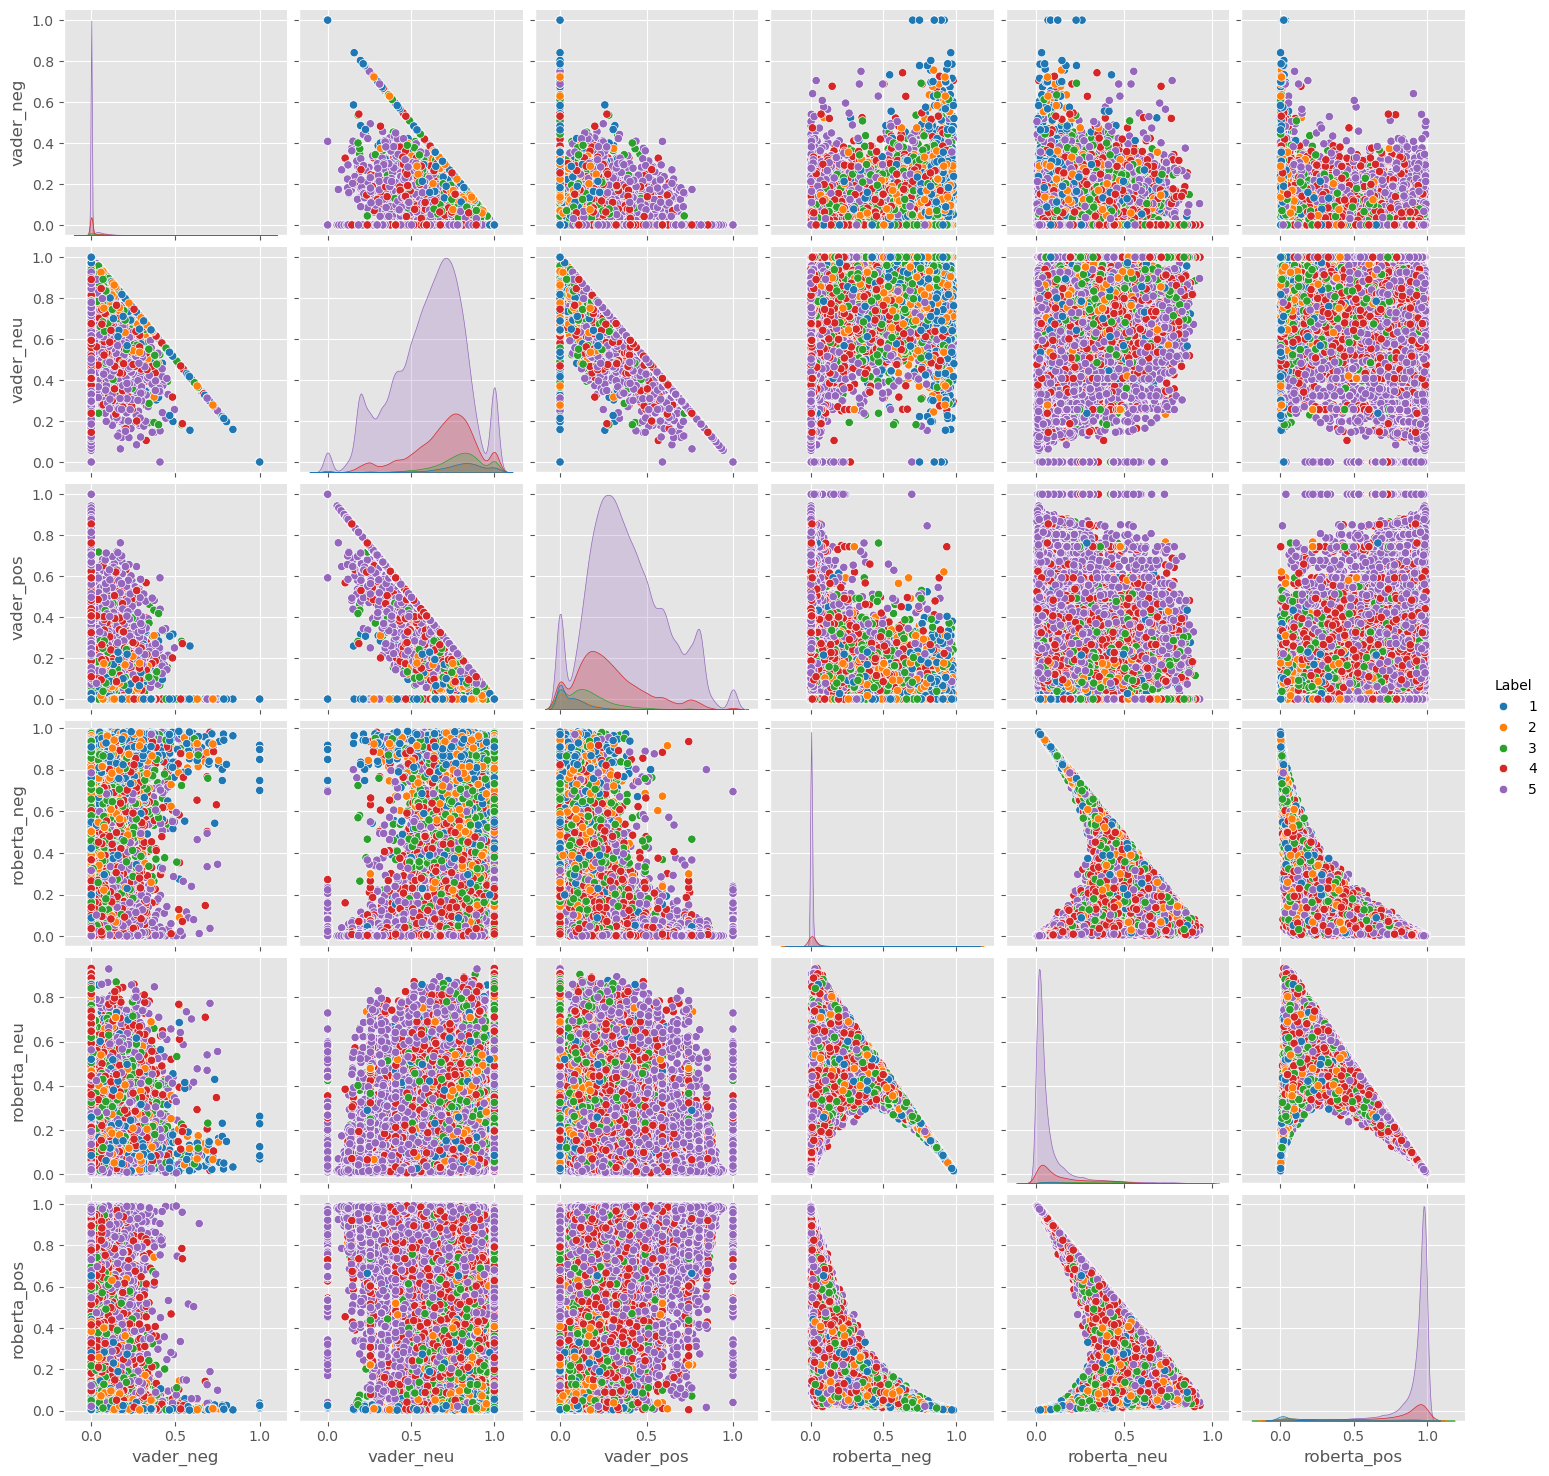

In [26]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Label',
            palette='tab10')
plt.show()

### Combine and compare

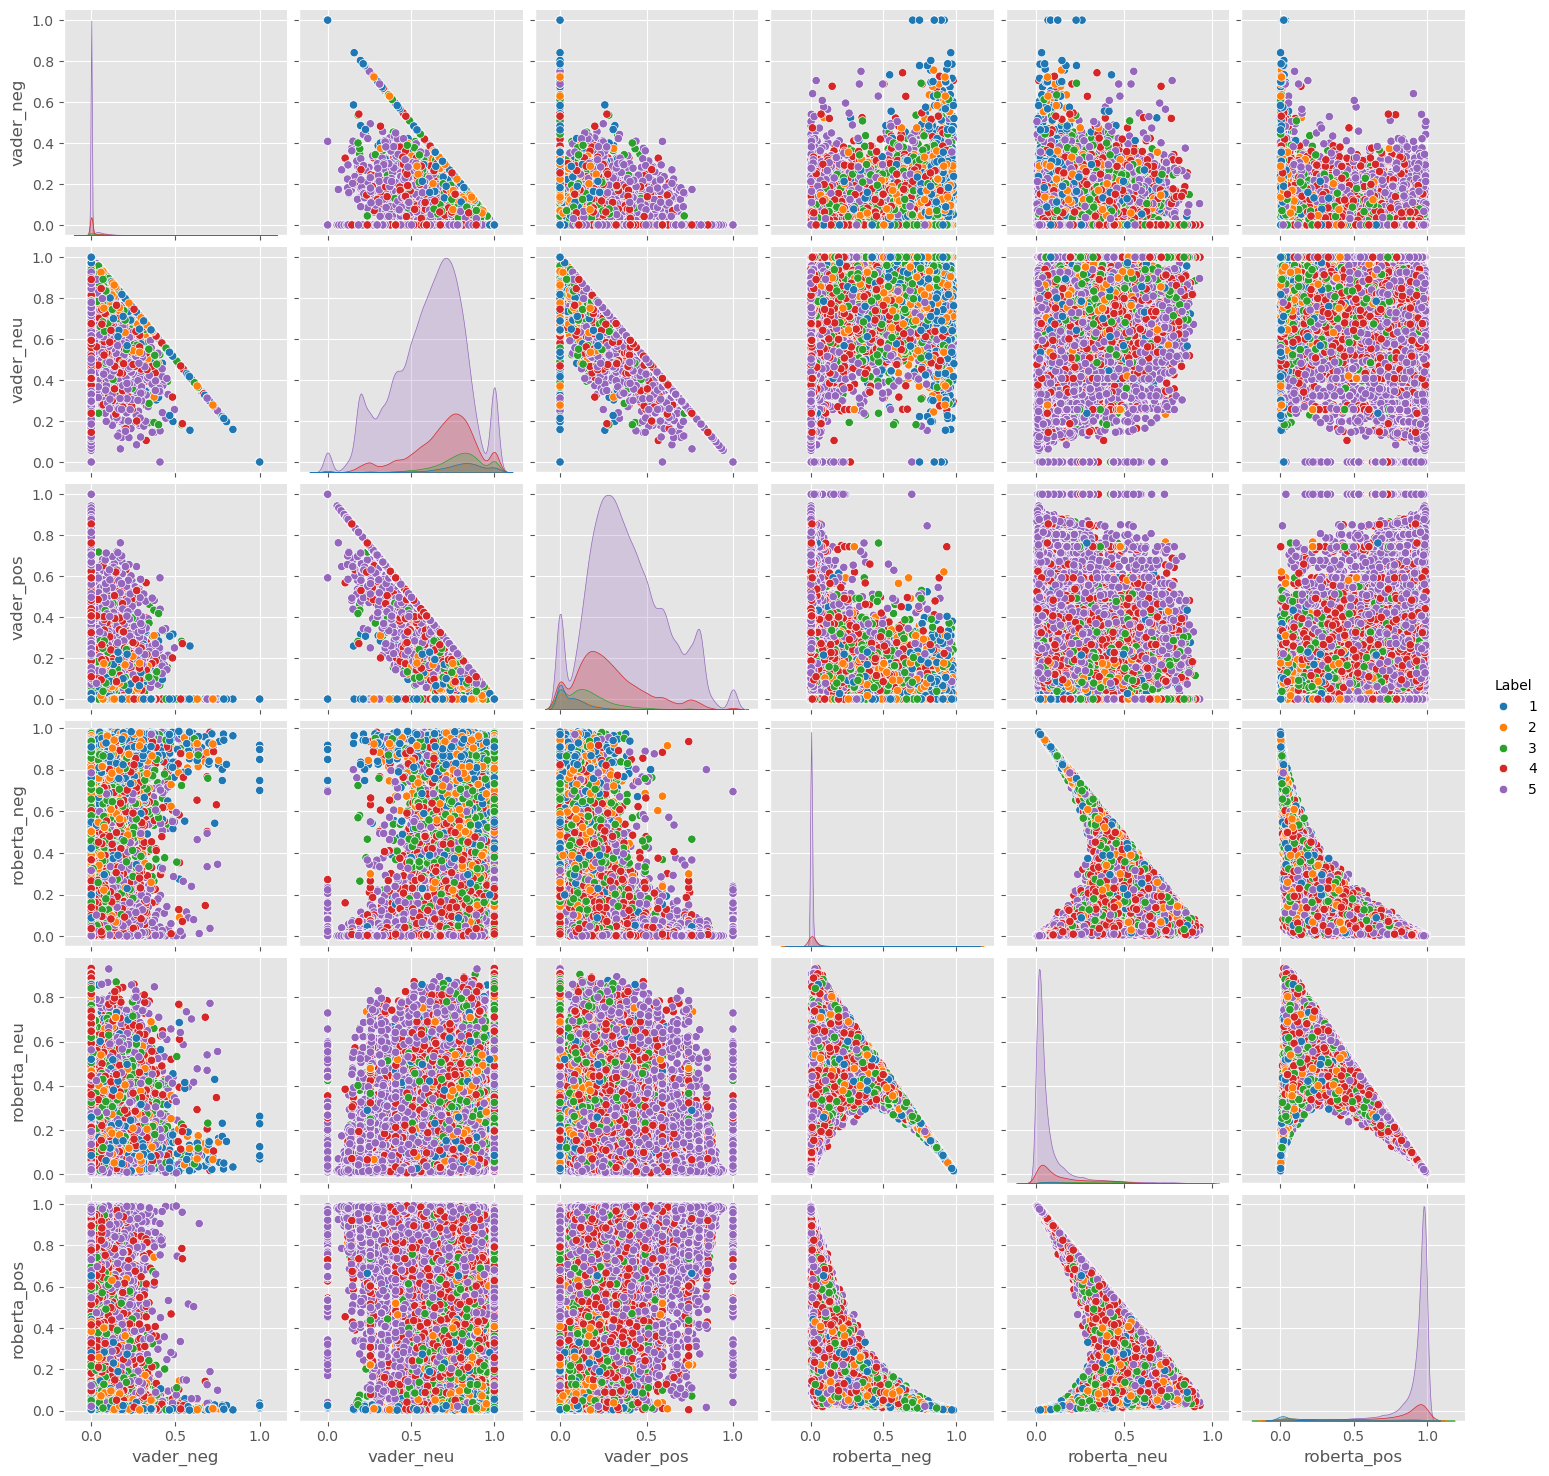

In [29]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Label',
            palette='tab10')
plt.show()